# Housing Supply Analysis
2017 - 2023, U.S.A.

**Author**: Samuel De La Paz

**Date**: December 5, 2025


# Executive Summary

# 1. Introduction

The housing affordability crisis has been at the forefront of American's minds for the last few years. There is debate between the need for rent freezes and the need for increased housing supply (sometimes people argue for a mix of both).

In this report, I will focus on the relationship between housing supply and rental rates by analyzing these variables and various other characteristics. I got inspiration for this idea after reading a [Pew Research](https://www.pew.org/en/research-and-analysis/articles/2025/07/31/new-housing-slows-rent-growth-most-for-older-more-affordable-units?utm_source=chatgpt.com) article on the effects of housing supply. I had no idea where they get their data from, and how they decide to analyze it. In the margin of the article, there is a [methodology page](https://www.pew.org/-/media/assets/2025/07/methodology-appendix--new-housing-slows-rent-growth-most-for-older-more-affordable-units.pdf) that vaguely explains where the data was collected from and what variables were used.

The rent data was collected from Zillow at the zip code level, and a majority of the remaining variables were collected from the American Community 5-year Survey (ACS). More is explained on them below.

The logical process of this report was led by myself, and I used Google Gemini to assist with creating the python code.

# 2. Data Collection
First, I import the required packages, saved my API key, and defined the years for the report. The original report used only the data from 2017 and 2023, but I wanted to look at the data at a more granular level and chose every intermediate year.

In order to replicate this notebook, request an API at the link below.

In [93]:
import pandas as pd
import numpy as np
import requests
import time
import io
from urllib.parse import urlparse
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
import statsmodels.api as sm
from google.colab import userdata

# Request a U.S. Census API Key here: https://api.census.gov/data/key_signup.html
# ACS API Key
API_KEY = userdata.get('API_KEY_ACS')

# Years to evaluate
YEARS = [2017, 2018, 2019, 2020, 2021, 2022, 2023]


## 2.1 Zillow Data

The data used from Zillow is the Zillow Observed Rent Index (ZORI) data set at the zip code level. This is a smoothed measure of observed market rate, calculated by the mean of listed rents that are within the 35th and 65th percentile range for all homes and apartments. I selected the "All Homes Plus Multifamily Time Series ($)" data set in order to focus on the aggregate rental market. The data is retrieved by simply downloading it from the website link. More information on the [ZORI methodology](https://www.zillow.com/research/methodology-zori-repeat-rent-27092/) can be found on their website.

In [3]:
# Direct download URL for the ZORI data (Smoothed, All Homes Plus Multifamily Time Series ($))
direct_download_url = 'https://files.zillowstatic.com/research/public_csvs/zori/Zip_zori_uc_sfrcondomfr_sm_month.csv?t=1764891605'

def download_ZORI(url):
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)

        df_zori = pd.read_csv(io.BytesIO(response.content), dtype = {'RegionName': str})
        print("Successfully loaded ZORI data from CSV.")

        # Rename Columns
        df_zori.rename(columns = {
            'RegionName': 'zip_code',
        }, inplace = True)

    except requests.exceptions.RequestException as e:
        print(f"Error downloading or accessing the file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return df_zori

In [4]:
df_zori = download_ZORI(direct_download_url)
display(df_zori.head())
print(f"\nShape of the ZORI DataFrame: {df_zori.shape}")

Successfully loaded ZORI data from CSV.


,RegionID,SizeRank,zip_code,RegionType,StateName,State,City,Metro,CountyName,2015-01-31,...,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1446.800181,...,1826.611050,1826.097192,1833.236446,1835.822982,1839.497247,1836.635459,1842.942791,1847.823585,1843.482332,1834.157854
1,61148,2,08701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2448.250000
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,1244.279053,...,1816.553864,1834.912006,1849.753183,1852.463718,1843.620912,1836.463587,1832.726878,1824.652472,1815.695326,1815.289702
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2675.000000
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,1102.475395,...,1588.773969,1605.034961,1606.770580,1609.123029,1586.395239,1587.864030,1584.814738,1594.553954,1592.929560,1587.545841



Shape of the ZORI DataFrame: (7822, 139)


There are 7,822 zip codes represented in this data set, and there are over 33,000 ZCTAs (ZIP Code Tabulation Areas) in the U.S., so the data set only captures a select group of ZIP codes. Also, from the inital head of the data, I see that the data is filled with empty values, with records saved either once a year or at random spots. I will clean this up at a later stage.

## 2.2 ACS Data

The [American Community Survey](https://www.census.gov/data/developers/data-sets/acs-5year.html) is conducted every year, however the 5-year data is the most accurate for smaller geographical areas since they are able to gather more information. The survey is accessed for both zip code level data as well as metropolitan level data for the variables specified in the Pew report.
The zip codes are represented by Census ZIP Code Tabulation Areas (ZCTA) and the metropolitan level statistics are represented by Core-based Statistical Areas (CBSA).

ZCTAs do not perfectly match to CBSA, since there is overlap. Some ZCTAs are in multiple CBSA regions. Therefore, I needed to link the ZCTAs to county codes (FIPS), then the county codes to the CBSA codes. Luckily, the ZCTA to county file contains the ZCTA area in square meters, which will be saved and used later to calcuate population density. Since the ZCTAs are split, the metropolitan area with the largest percentage of the ZCTA land area will get linked to the ZCTA for simplicity. After calling the API and downloading data for all 7 years, the final dataset is merged. The column names are also cryptic, using codes specific to the census, so in order to keep track of the meaning of the columns, sensible column names are assigned to each column header.

In [6]:
# Variable mapping
# ZIP CODE LEVEL VARIABLES
ZIP_VARIABLES = {
    'B01003_001E': 'population',
    'B19013_001E': 'median_household_income',
    'B25077_001E': 'median_home_value',
    'B25064_001E': 'median_gross_rent',
    'B25071_001E': 'median_rent_burden_percent',
    'B19083_001E': 'gini_inequality_index',
    'B25001_001E': 'total_housing_units',
    'B02001_001E': 'race_total',
    'B02001_002E': 'race_white_alone',
    'B02001_003E': 'race_black_alone',
    'B25003_001E': 'tenure_total_occupied',
    'B25003_003E': 'tenure_renter_occupied',
    'B08301_001E': 'commute_total_workers',
    'B08301_010E': 'commute_public_transit',
    'B08301_018E': 'commute_bicycle',
    'B08301_019E': 'commute_walk',
    'B08301_021E': 'commute_worked_from_home',
}

# BASIC MSA VARIABLES (Likely to succeed in all years)
MSA_BASIC_VARIABLES = {
    'NAME': 'msa_name',
    'B01003_001E': 'msa_population',
    'B25077_001E': 'msa_median_home_value',
    'B25001_001E': 'msa_total_housing_units',
    'B01002_001E': 'msa_median_age',
}

# API Call Function
def get_census_data(year, variables, geography, api_key):
    """
    Generic function to fetch ACS data.
    """
    base_url = f"https://api.census.gov/data/{year}/acs/acs5"

    # Chunk variables to avoid URL length issues (though 50 is usually safe)
    cols = list(variables.keys())
    get_params = ",".join(cols)

    params = {
        'get': get_params,
        'for': geography,
        'key': api_key
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])
        return df
    except requests.exceptions.HTTPError as e:
        # We print the error but don't crash, returning empty DF allows logic to continue
        print(f"  X API Error ({year}): {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"  X Generic Error ({year}): {e}")
        return pd.DataFrame()

def link_zip_to_cbsa_data(zip_df, cbsa_stats_df):
    """
    Links a dataframe of ZIP codes to CBSA statistics using 2020 Census crosswalks.

    Parameters:
    - zip_df: DataFrame with a column 'zip_code' (the ZCTAs).
    - cbsa_stats_df: DataFrame with a column 'cbsa_code' (statistics to join).

    Returns:
    - merged_df: The original zip_df enriched with CBSA info and statistics.
    """

    # --- URLS FOR OFFICIAL CENSUS 2020 FILES ---
    # ZCTA to County Relationship File (Pipe-delimited)
    ZCTA_REL_URL = "https://www2.census.gov/geo/docs/maps-data/data/rel2020/zcta520/tab20_zcta520_county20_natl.txt"
    # County to CBSA Delineation File (Excel, March 2020)
    CBSA_DEL_URL = "https://www2.census.gov/programs-surveys/metro-micro/geographies/reference-files/2020/delineation-files/list1_2020.xls"

    print("Step 1: Loading ZCTA-to-County Relationship File...")
    # Read the pipe-delimited text file directly from URL
    # dtype={'GEOID_ZCTA5_20': str, 'GEOID_COUNTY_20': str} ensures we keep leading zeros
    zcta_rel = pd.read_csv(
        ZCTA_REL_URL,
        sep='|',
        dtype={'GEOID_ZCTA5_20': str, 'GEOID_COUNTY_20': str}
    )

    # --- LOGIC TO HANDLE ZCTAS SPLIT ACROSS COUNTIES ---
    # Many ZCTAs span multiple counties. We must pick ONE county per ZCTA to avoid duplicating data.
    # We sort by 'AREALAND_PART' (land area in that county) and keep the largest part.
    zcta_rel_unique = zcta_rel.sort_values('AREALAND_PART', ascending=False).drop_duplicates('GEOID_ZCTA5_20')

    # Rename columns for clarity
    # Keep land area (square meters) of ZCTA to calculate population density
    zcta_rel_unique = zcta_rel_unique[['GEOID_ZCTA5_20', 'GEOID_COUNTY_20', 'AREALAND_ZCTA5_20']].rename(
        columns={'GEOID_ZCTA5_20': 'zip_code', 'GEOID_COUNTY_20': 'fips_county',
                 'AREALAND_ZCTA5_20': 'zip_area_sm'}
    )

    print("Step 2: Loading County-to-CBSA Delineation File...")
    # Read Excel file. Header is usually on row 3 (index 2) for these Census files.
    # We need 'CBSA Code', 'FIPS State Code', and 'FIPS County Code'.
    cbsa_rel = pd.read_excel(
        CBSA_DEL_URL,
        header=2,
        dtype={'CBSA Code': str, 'FIPS State Code': str, 'FIPS County Code': str}
    )

    # Create the full 5-digit FIPS code to match the ZCTA file
    cbsa_rel['fips_county'] = cbsa_rel['FIPS State Code'] + cbsa_rel['FIPS County Code']

    # Keep only the mapping columns
    # Note: Some counties belong to multiple CBSAs (rare) or Divisions.
    # We drop duplicates on fips_county to ensure 1:1 mapping for the main CBSA.
    cbsa_rel_clean = cbsa_rel[['fips_county', 'CBSA Code', 'CBSA Title']].drop_duplicates('fips_county')
    cbsa_rel_clean = cbsa_rel_clean.rename(columns={'CBSA Code': 'cbsa_code'})

    # --- STEP 3: EXECUTE MERGES ---
    print("Step 3: Merging Dataframes...")

    # Ensure input ZIPs are strings and padded to 5 digits
    zip_df['zip_code'] = zip_df['zip_code'].astype(str).str.zfill(5)

    # 1. Merge User ZIPs -> Census Counties
    merged_step1 = pd.merge(zip_df, zcta_rel_unique, on='zip_code', how='left')

    # 2. Merge Result -> Census CBSAs
    merged_step2 = pd.merge(merged_step1, cbsa_rel_clean, on='fips_county', how='left')

    # 3. Merge Result -> User CBSA Statistics (Second Dataframe)
    # Ensure join key is string
    if 'cbsa_code' in cbsa_stats_df.columns:
        cbsa_stats_df['cbsa_code'] = cbsa_stats_df['cbsa_code'].astype(str)

    final_df = pd.merge(merged_step2, cbsa_stats_df, on='cbsa_code', how='left')

    return final_df

In [7]:
# Begin dowloading data
all_final_data = []


for year in YEARS:
    print(f"\nProcessing Year: {year}...")

    # --- A. Fetch Zip Data ---
    print(f"  Fetching Zip Code Data...")
    df_zip = get_census_data(year, ZIP_VARIABLES, 'zip code tabulation area:*', API_KEY)
    if df_zip.empty:
        print("  Skipping year (Zip fetch failed).")
        continue

    df_zip.rename(columns=ZIP_VARIABLES, inplace=True)

    # Rename geo column
    df_zip.rename(columns={'zip code tabulation area': 'zip_code'}, inplace=True)

    # --- B. Fetch MSA Data ---
    print(f"  Fetching MSA Data (Basic)...")
    df_msa_basic = get_census_data(year, MSA_BASIC_VARIABLES, 'metropolitan statistical area/micropolitan statistical area:*', API_KEY)

    # Rename known columns
    df_msa_basic.rename(columns=MSA_BASIC_VARIABLES, inplace=True)

    # Rename geo column
    df_msa_basic.rename(columns={'metropolitan statistical area/micropolitan statistical area': 'cbsa_code'}, inplace=True)

    # --- C. Process and Join ---
    final_year = link_zip_to_cbsa_data(df_zip, df_msa_basic)
    final_year['survey_year'] = f"{year-4}-{year}"
    final_year['survey_end_year'] = year
    all_final_data.append(final_year)

    time.sleep(1)

    if all_final_data:
        full_df = pd.concat(all_final_data, ignore_index=True)
        filename = "acs_zip_msa_combined_v2.csv"
        full_df.to_csv(filename, index=False)
        print(f"\nSuccess! Saved {len(full_df)} rows to {filename}")
    else:
        print("No data collected.")


Processing Year: 2017...
  Fetching Zip Code Data...
  Fetching MSA Data (Basic)...
Step 1: Loading ZCTA-to-County Relationship File...
Step 2: Loading County-to-CBSA Delineation File...
Step 3: Merging Dataframes...

Success! Saved 33120 rows to acs_zip_msa_combined_v2.csv

Processing Year: 2018...
  Fetching Zip Code Data...
  Fetching MSA Data (Basic)...
Step 1: Loading ZCTA-to-County Relationship File...
Step 2: Loading County-to-CBSA Delineation File...
Step 3: Merging Dataframes...

Success! Saved 66240 rows to acs_zip_msa_combined_v2.csv

Processing Year: 2019...
  Fetching Zip Code Data...
  Fetching MSA Data (Basic)...
Step 1: Loading ZCTA-to-County Relationship File...
Step 2: Loading County-to-CBSA Delineation File...
Step 3: Merging Dataframes...

Success! Saved 99360 rows to acs_zip_msa_combined_v2.csv

Processing Year: 2020...
  Fetching Zip Code Data...
  Fetching MSA Data (Basic)...
Step 1: Loading ZCTA-to-County Relationship File...
Step 2: Loading County-to-CBSA Deli

In [8]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233800 entries, 0 to 233799
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   population                  233800 non-null  object 
 1   median_household_income     233765 non-null  object 
 2   median_home_value           233800 non-null  object 
 3   median_gross_rent           233800 non-null  object 
 4   median_rent_burden_percent  233765 non-null  object 
 5   gini_inequality_index       233765 non-null  object 
 6   total_housing_units         233800 non-null  object 
 7   race_total                  233800 non-null  object 
 8   race_white_alone            233800 non-null  object 
 9   race_black_alone            233800 non-null  object 
 10  tenure_total_occupied       233800 non-null  object 
 11  tenure_renter_occupied      233800 non-null  object 
 12  commute_total_workers       233765 non-null  object 
 13  commute_public

There is a significant mismatch between the number of metropolitan level statistics and zip code level values. This is because not every ZCTA is assigned to a metropolitan area (i.e. rural areas), but since Zillow's data only covers metropolitan areas, this difference is negligible.

# 3. Data Formatting

In order to run a proper analysis, the format of the data and the data types need to be fixed.

## 3.1 Format Zillow Data
The Zillow data is in "wide" format, with every column representing a month. In order for the data to be relevant, I need a value for each year. Therefore, I am taking the average of each rent value for each year. Some zip codes will have multiple months of data and others may only have one month. Since we are taking the average, and it is unlikely that rent values will change drastically in the course of the year, this is a reasonable approach.

In [9]:
# Identify non-monthly ZORI columns (id_vars)
id_vars = ['RegionID', 'SizeRank', 'zip_code', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']

# Get all column names from df_zori
all_columns = df_zori.columns.tolist()

# Determine the monthly ZORI columns (value_vars) by excluding id_vars
monthly_zori_cols = [col for col in all_columns if col not in id_vars]

# Melt the DataFrame to transform monthly data into a long format
df_zori_melted = pd.melt(df_zori,
                         id_vars=id_vars,
                         value_vars=monthly_zori_cols,
                         var_name='date',
                         value_name='zori_value')

# Convert the 'date' column to datetime objects
df_zori_melted['date'] = pd.to_datetime(df_zori_melted['date'])

# Extract the year from the 'date' column
df_zori_melted['year'] = df_zori_melted['date'].dt.year

# Filter the data to include only the years of analysis
df_zori_melted = df_zori_melted[df_zori_melted['year'].isin(YEARS)].copy()

# Display the first few rows and information about the processed DataFrame
print("df_zori_melted head:")
print(df_zori_melted.head())
print("\ndf_zori_melted info:")
print(df_zori_melted.info())

df_zori_melted head:
        RegionID  SizeRank zip_code RegionType StateName State      City  \
187728     91982         1    77494        zip        TX    TX      Katy   
187729     61148         2    08701        zip        NJ    NJ  Lakewood   
187730     91940         3    77449        zip        TX    TX      Katy   
187731     62080         4    11368        zip        NY    NY  New York   
187732     91733         5    77084        zip        TX    TX   Houston   

                                        Metro        CountyName       date  \
187728   Houston-The Woodlands-Sugar Land, TX  Fort Bend County 2017-01-31   
187729  New York-Newark-Jersey City, NY-NJ-PA      Ocean County 2017-01-31   
187730   Houston-The Woodlands-Sugar Land, TX     Harris County 2017-01-31   
187731  New York-Newark-Jersey City, NY-NJ-PA     Queens County 2017-01-31   
187732   Houston-The Woodlands-Sugar Land, TX     Harris County 2017-01-31   

         zori_value  year  
187728  1365.807519  2017

In [10]:
# Calculate the yearly average ZORI for each zip code
# mean() automatically handles NaN values
df_zori_yearly_avg = df_zori_melted.groupby(['zip_code', 'year', 'State', 'City', 'Metro'])['zori_value'].mean().reset_index()

# Rename average_zori
df_zori_yearly_avg.rename(columns={'zori_value': 'average_zori'}, inplace=True)

# Display the first few rows and information about the processed DataFrame
print("df_zori_yearly_avg head:")
print(df_zori_yearly_avg.head())
print("\ndf_zori_yearly_avg info:")
print(df_zori_yearly_avg.info())

df_zori_yearly_avg head:
  zip_code  year State     City            Metro  average_zori
0    01002  2017    MA  Amherst  Springfield, MA           NaN
1    01002  2018    MA  Amherst  Springfield, MA           NaN
2    01002  2019    MA  Amherst  Springfield, MA           NaN
3    01002  2020    MA  Amherst  Springfield, MA           NaN
4    01002  2021    MA  Amherst  Springfield, MA           NaN

df_zori_yearly_avg info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54082 entries, 0 to 54081
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zip_code      54082 non-null  object 
 1   year          54082 non-null  int32  
 2   State         54082 non-null  object 
 3   City          54082 non-null  object 
 4   Metro         54082 non-null  object 
 5   average_zori  21757 non-null  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 2.3+ MB
None


In [11]:
# Identify zip codes that have non-NaN average_zori for each of the YEARS
valid_zori_per_year = df_zori_yearly_avg[df_zori_yearly_avg['average_zori'].notna()]

# Count how many of the YEARS each zip code has valid data for
valid_year_counts = valid_zori_per_year.groupby('zip_code')['year'].nunique().reset_index()
valid_year_counts.rename(columns={'year': 'valid_zori_year_count'}, inplace=True)

# Filter for zip codes that have valid data for all YEARS
zips_with_all_years_data = valid_year_counts[valid_year_counts['valid_zori_year_count'] == len(YEARS)]['zip_code']

# Filter the original df_zori_yearly_avg to only include these zip codes
df_zori_yearly_avg_filtered = df_zori_yearly_avg[df_zori_yearly_avg['zip_code'].isin(zips_with_all_years_data)].copy()

print("Original df_zori_yearly_avg shape:", df_zori_yearly_avg.shape)
print("Filtered df_zori_yearly_avg_filtered shape:", df_zori_yearly_avg_filtered.shape)
print("Original df_zori_yearly_avg number of zip_codes:", df_zori_yearly_avg['zip_code'].nunique())
print("Filtered df_zori_yearly_avg_filtered number of zip_codes:", df_zori_yearly_avg_filtered['zip_code'].nunique())
print("\nFirst 5 rows of filtered DataFrame:")
display(df_zori_yearly_avg_filtered.head())

Original df_zori_yearly_avg shape: (54082, 6)
Filtered df_zori_yearly_avg_filtered shape: (12642, 6)
Original df_zori_yearly_avg number of zip_codes: 7726
Filtered df_zori_yearly_avg_filtered number of zip_codes: 1806

First 5 rows of filtered DataFrame:


,zip_code,year,State,City,Metro,average_zori
553,01970,2017,MA,Salem,"Boston-Cambridge-Newton, MA-NH",1729.152951
554,01970,2018,MA,Salem,"Boston-Cambridge-Newton, MA-NH",1825.697741
555,01970,2019,MA,Salem,"Boston-Cambridge-Newton, MA-NH",1903.133152
556,01970,2020,MA,Salem,"Boston-Cambridge-Newton, MA-NH",1979.941114
557,01970,2021,MA,Salem,"Boston-Cambridge-Newton, MA-NH",2096.282038


## 3.2 Format ACS Data
Some variables from the report are not immediately available from ACS, so they have to be calculated, such as the share of the population that is non-white, the rentership rate, population density, and the share of people that work from home. It's also important to save the numeric columns as numeric data types in order to compute these variables as well as for future analysis.

In [12]:
# Save a copy
acs_df = full_df.copy()
zip_val = set(ZIP_VARIABLES.values())
msa_val = set(MSA_BASIC_VARIABLES.values())
combined_val = zip_val.union(msa_val)
combined_val.remove('msa_name')
numeric_cols = [c for c in acs_df.columns if c in combined_val]

for col in numeric_cols:
    acs_df[col] = pd.to_numeric(acs_df[col], errors='coerce')

# Derived Zip Stats
# Race share
acs_df['non_white_pop_share'] = (acs_df['race_total'] - acs_df['race_white_alone']) / acs_df['race_total']
acs_df['white_pop_share'] = acs_df['race_white_alone'] / acs_df['race_total']
acs_df['black_pop_share'] = acs_df['race_black_alone'] / acs_df['race_total']
# Rentership share
acs_df['rentership_rate'] = acs_df['tenure_renter_occupied'] / acs_df['tenure_total_occupied']
# Commute share
transit_nonmotor = acs_df['commute_public_transit'] + acs_df['commute_bicycle'] + acs_df['commute_walk']
acs_df['share_transit_nonmotorized'] = transit_nonmotor / acs_df['commute_total_workers']
acs_df['share_work_from_home'] = acs_df['commute_worked_from_home'] / acs_df['commute_total_workers']
# Population density (per square meter converted to per square mile)
acs_df['zip_pop_density_sq_mi'] = acs_df['population'] / (acs_df['zip_area_sm']/(2589988.11))


print(acs_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233800 entries, 0 to 233799
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   population                  233800 non-null  int64  
 1   median_household_income     233765 non-null  float64
 2   median_home_value           233800 non-null  int64  
 3   median_gross_rent           233800 non-null  int64  
 4   median_rent_burden_percent  233765 non-null  float64
 5   gini_inequality_index       233765 non-null  float64
 6   total_housing_units         233800 non-null  int64  
 7   race_total                  233800 non-null  int64  
 8   race_white_alone            233800 non-null  int64  
 9   race_black_alone            233800 non-null  int64  
 10  tenure_total_occupied       233800 non-null  int64  
 11  tenure_renter_occupied      233800 non-null  int64  
 12  commute_total_workers       233765 non-null  float64
 13  commute_public

## 3.3 Merge Zillow Data with ACS Data
Luckily, merging the data sets is not too difficult since both are already in terms of zip code. This will drastically reduce the size of the ACS data set.

In [23]:
rent_df = df_zori_yearly_avg_filtered.merge(acs_df, left_on = ['zip_code', 'year'], right_on = ['zip_code', 'survey_end_year'], how = 'left')

print(rent_df.head())
print(rent_df.info())

  zip_code  year State   City                           Metro  average_zori  \
0    01970  2017    MA  Salem  Boston-Cambridge-Newton, MA-NH   1729.152951   
1    01970  2018    MA  Salem  Boston-Cambridge-Newton, MA-NH   1825.697741   
2    01970  2019    MA  Salem  Boston-Cambridge-Newton, MA-NH   1903.133152   
3    01970  2020    MA  Salem  Boston-Cambridge-Newton, MA-NH   1979.941114   
4    01970  2021    MA  Salem  Boston-Cambridge-Newton, MA-NH   2096.282038   

   population  median_household_income  median_home_value  median_gross_rent  \
0     42991.0                  65476.0           331300.0             1147.0   
1     43155.0                  65495.0           347200.0             1235.0   
2     43033.0                  68860.0           367200.0             1284.0   
3     43120.0                  66495.0           379400.0             1321.0   
4     44372.0                  72994.0           396700.0             1489.0   

   ...  msa_median_age  survey_year  survey_

## 3.4 Calculate Rates of Change
Lastly, percent changes are calculated for certain variables (e.g. average rent, total housing units, population) and added to the data set.

In [28]:
# Sort by zip_code and year for correct year-over-year calculations
rent_df = rent_df.sort_values(by=['zip_code', 'year'])

# --- Calculate Year-to-Year Changes for Zip-level variables ---

# Year to year Change in Rent (average_zori)
rent_df['yoy_pct_change_average_zori'] = rent_df.groupby('zip_code')['average_zori'].pct_change(fill_method=None) * 100

# Year to year Change in Housing Supply (total_housing_units)
rent_df['yoy_pct_change_total_housing_units'] = rent_df.groupby('zip_code')['total_housing_units'].pct_change(fill_method=None) * 100

# Year to year Change in population (population)
rent_df['yoy_pct_change_population'] = rent_df.groupby('zip_code')['population'].pct_change(fill_method=None) * 100

# Year to year Change in work from home (share_work_from_home) - using absolute change as percentage might be misleading if base is small
rent_df['yoy_abs_change_share_work_from_home'] = rent_df.groupby('zip_code')['share_work_from_home'].diff()

# Year to year Change in income (median_household_income)
rent_df['yoy_pct_change_median_household_income'] = rent_df.groupby('zip_code')['median_household_income'].pct_change(fill_method=None) * 100

# Year to year Change in home value (median_home_value)
rent_df['yoy_pct_change_median_home_value'] = rent_df.groupby('zip_code')['median_home_value'].pct_change(fill_method=None) * 100

# Save dataset to csv
rent_df.to_csv('rent_df.csv', index=False)

# Display info and head of the modified dataframe
print(rent_df.info())
print(rent_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12642 entries, 0 to 12641
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   zip_code                                12642 non-null  object 
 1   year                                    12642 non-null  int32  
 2   State                                   12642 non-null  object 
 3   City                                    12642 non-null  object 
 4   Metro                                   12642 non-null  object 
 5   average_zori                            12642 non-null  float64
 6   population                              12630 non-null  float64
 7   median_household_income                 12630 non-null  float64
 8   median_home_value                       12630 non-null  float64
 9   median_gross_rent                       12630 non-null  float64
 10  median_rent_burden_percent              12630 non-null  fl

# 4. Preliminary Exploratory Data Analysis

## 4.1 Values

After reviewing the output, I notice there are 6 values that are missing metropolitan level statistics. I identify and print them out.

In [62]:
# Identify rows with null MSA name
null_msa = rent_df[rent_df['msa_name'].isnull()]

# Filter for the 6 rows that have valid population data despite missing MSA data
# (The other 12 rows are missing population data as well)
rows_of_interest = null_msa[null_msa['population'].notnull()]

# Select the requested columns
result_table = rows_of_interest[['zip_code', 'year', 'City', 'State', 'Metro']]

# Print the table
print(result_table.to_markdown(index=False))

|   zip_code |   year | City               | State   | Metro                        |
|-----------:|-------:|:-------------------|:--------|:-----------------------------|
|      44107 |   2023 | Lakewood           | OH      | Cleveland-Elyria, OH         |
|      44118 |   2023 | University Heights | OH      | Cleveland-Elyria, OH         |
|      45424 |   2017 | Huber Heights      | OH      | Dayton-Kettering, OH         |
|      45424 |   2018 | Huber Heights      | OH      | Dayton-Kettering, OH         |
|      86314 |   2017 | Prescott Valley    | AZ      | Prescott Valley-Prescott, AZ |
|      86314 |   2018 | Prescott Valley    | AZ      | Prescott Valley-Prescott, AZ |


Next, I want to see the summary of the data we are dealing with.

In [64]:
# Calculate the number of unique values for each specified column
num_unique_zip = rent_df['zip_code'].nunique()
num_unique_states = rent_df['State'].nunique()
num_unique_cbsa = rent_df['cbsa_code'].nunique()
num_unique_survey_years = rent_df['survey_year'].nunique()

# Create a summary DataFrame
summary_table = pd.DataFrame({
    'Category': ['Unique States', 'Unique CBSA Codes (Metros)', 'Unique Zip Codes', 'Unique Survey Years'],
    'Count': [num_unique_states, num_unique_cbsa, num_unique_zip, num_unique_survey_years]
})

# Print the summary table
print(summary_table.to_markdown(index=False))

| Category                   |   Count |
|:---------------------------|--------:|
| Unique States              |      47 |
| Unique CBSA Codes (Metros) |     157 |
| Unique Zip Codes           |    1806 |
| Unique Survey Years        |       7 |


This data set contains zip codes from 47 states, 157 metropolitan areas, 1,806 zip codes, and 7 years.

Next, I want to observe where the places with the highest rents are, as well as the lowest rents.

In [69]:
# Sort by average rent (average_zori) in descending order
df_sorted = rent_df.sort_values(by='average_zori', ascending=False)

# Drop duplicates based on 'zip_code', keeping the first (highest rent)
df_unique_zips = df_sorted.drop_duplicates(subset='zip_code', keep='first')

# Select the top 10
top_10_rents = df_unique_zips.head(10)

# Select the requested columns
columns_to_show = ['zip_code', 'City', 'msa_name', 'year', 'average_zori']
result_table = top_10_rents[columns_to_show]

# Print the table
print(result_table.to_markdown(index=False))

|   zip_code | City          | msa_name                                      |   year |   average_zori |
|-----------:|:--------------|:----------------------------------------------|-------:|---------------:|
|      11937 | East Hampton  | New York-Newark-Jersey City, NY-NJ Metro Area |   2023 |       40611.9  |
|      11968 | Southampton   | New York-Newark-Jersey City, NY-NJ Metro Area |   2023 |       38213.2  |
|      90265 | Malibu        | Los Angeles-Long Beach-Anaheim, CA Metro Area |   2023 |        7961.18 |
|      90210 | Beverly Hills | Los Angeles-Long Beach-Anaheim, CA Metro Area |   2023 |        7644.68 |
|      10007 | New York      | New York-Newark-Jersey City, NY-NJ Metro Area |   2023 |        6455.56 |
|      90402 | Santa Monica  | Los Angeles-Long Beach-Anaheim, CA Metro Area |   2023 |        5530.36 |
|      10069 | New York      | New York-Newark-Jersey City, NY-NJ Metro Area |   2023 |        5214.43 |
|      11249 | New York      | New York-Newark-Jersey C

In [70]:
# Sort by average rent (average_zori) in ascending order to find the lowest
df_sorted_lowest = rent_df.sort_values(by='average_zori', ascending=True)

# Drop duplicates based on 'zip_code', keeping the first (lowest rent)
df_unique_zips_lowest = df_sorted_lowest.drop_duplicates(subset='zip_code', keep='first')

# Select the top 10 (which are the lowest rents)
lowest_10_rents = df_unique_zips_lowest.head(10)

# Select the requested columns
columns_to_show = ['zip_code', 'City', 'msa_name', 'year', 'average_zori']
result_table_lowest = lowest_10_rents[columns_to_show]

# Print the table
print(result_table_lowest.to_markdown(index=False))

|   zip_code | City         | msa_name                                      |   year |   average_zori |
|-----------:|:-------------|:----------------------------------------------|-------:|---------------:|
|      46219 | Indianapolis | Indianapolis-Carmel-Anderson, IN Metro Area   |   2017 |        577.055 |
|      85705 | Tucson       | Tucson, AZ Metro Area                         |   2017 |        577.888 |
|      87108 | Albuquerque  | Albuquerque, NM Metro Area                    |   2017 |        579.952 |
|      46218 | Indianapolis | Indianapolis-Carmel-Anderson, IN Metro Area   |   2017 |        586.924 |
|      67213 | Wichita      | Wichita, KS Metro Area                        |   2017 |        594.302 |
|      40203 | Louisville   | Louisville/Jefferson County, KY-IN Metro Area |   2017 |        596.266 |
|      45211 | Cincinnati   | Cincinnati, OH-KY-IN Metro Area               |   2017 |        608.251 |
|      46201 | Indianapolis | Indianapolis-Carmel-Anderson, IN M

I am not suprised to see the Hamptons, Beverly Hills, or Malibu at the top of the list. The list of lower rents is much more diversified around the Midwest and Southwest.

Next I want to observe the top (and bottom areas) for changes in housing supply.

In [73]:
# Find the 10 zip codes with the highest YoY % change in housing units
# Sort by yoy_pct_change_total_housing_units descending
df_highest_pct = rent_df.sort_values(by='yoy_pct_change_total_housing_units', ascending=False)
# Keep unique zip codes, keeping the one with the max change
df_highest_pct_unique = df_highest_pct.drop_duplicates(subset='zip_code', keep='first')
top_10_highest_pct = df_highest_pct_unique.head(10)

# Find the 10 zip codes with the lowest (most negative) YoY % change in housing units
# Sort by yoy_pct_change_total_housing_units ascending
df_lowest_pct = df.sort_values(by='yoy_pct_change_total_housing_units', ascending=True)
# Keep unique zip codes, keeping the one with the min change
df_lowest_pct_unique = df_lowest_pct.drop_duplicates(subset='zip_code', keep='first')
top_10_lowest_pct = df_lowest_pct_unique.head(10)

# Select columns to display
columns_to_show = ['zip_code', 'City', 'msa_name', 'year', 'yoy_pct_change_total_housing_units']

print("Top 10 Zip Codes with Highest YoY % Change in Housing Units:")
print(top_10_highest_pct[columns_to_show].to_markdown(index=False))

print("\nTop 10 Zip Codes with Lowest (Most Negative) YoY % Change in Housing Units:")
print(top_10_lowest_pct[columns_to_show].to_markdown(index=False))

Top 10 Zip Codes with Highest YoY % Change in Housing Units:
|   zip_code | City        | msa_name                                      |   year |   yoy_pct_change_total_housing_units |
|-----------:|:------------|:----------------------------------------------|-------:|-------------------------------------:|
|      78253 | San Antonio | San Antonio-New Braunfels, TX Metro Area      |   2021 |                              60.1315 |
|      33896 | Davenport   | Orlando-Kissimmee-Sanford, FL Metro Area      |   2021 |                              59.1514 |
|      32827 | Orlando     | Orlando-Kissimmee-Sanford, FL Metro Area      |   2021 |                              52.072  |
|      29492 | Charleston  | Charleston-North Charleston, SC Metro Area    |   2021 |                              42.5998 |
|      90094 | Los Angeles | Los Angeles-Long Beach-Anaheim, CA Metro Area |   2021 |                              36.0304 |
|      78109 | Converse    | San Antonio-New Braunfels, TX Metro

This code finds the overall winners and losers from all years, so I find it odd that the year 2021 is selected. I will dive into this a little later.

## 4.2 Individual Variable Characteristics

The first variable I want to observe is the average rent. I will plot a histogram and observe the difference between the first and last years.

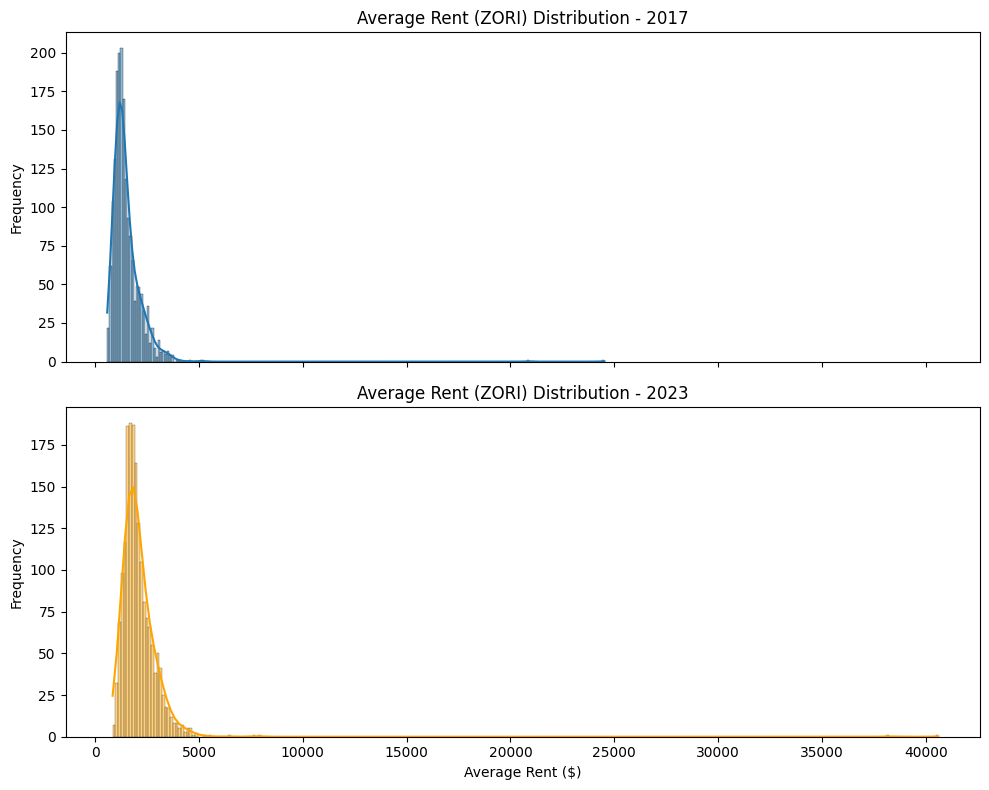

In [57]:
# Filter data for the specific years
df_2017 = rent_df[rent_df['year'] == 2017]
df_2023 = rent_df[rent_df['year'] == 2023]

# Create subplots (2 rows, 1 column)
# sharex=True aligns the x-axis for easier comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for 2017 on the top subplot (axes[0])
sns.histplot(df_2017['average_zori'], ax=axes[0], kde=True)
axes[0].set_title('Average Rent (ZORI) Distribution - 2017')
axes[0].set_ylabel('Frequency')

# Plot for 2023 on the bottom subplot (axes[1])
sns.histplot(df_2023['average_zori'], ax=axes[1], kde=True, color='orange')
axes[1].set_title('Average Rent (ZORI) Distribution - 2023')
axes[1].set_xlabel('Average Rent ($)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Clearly, the Hamptons are outliers that dominate the graph. I will zoom in to get a more clear look.

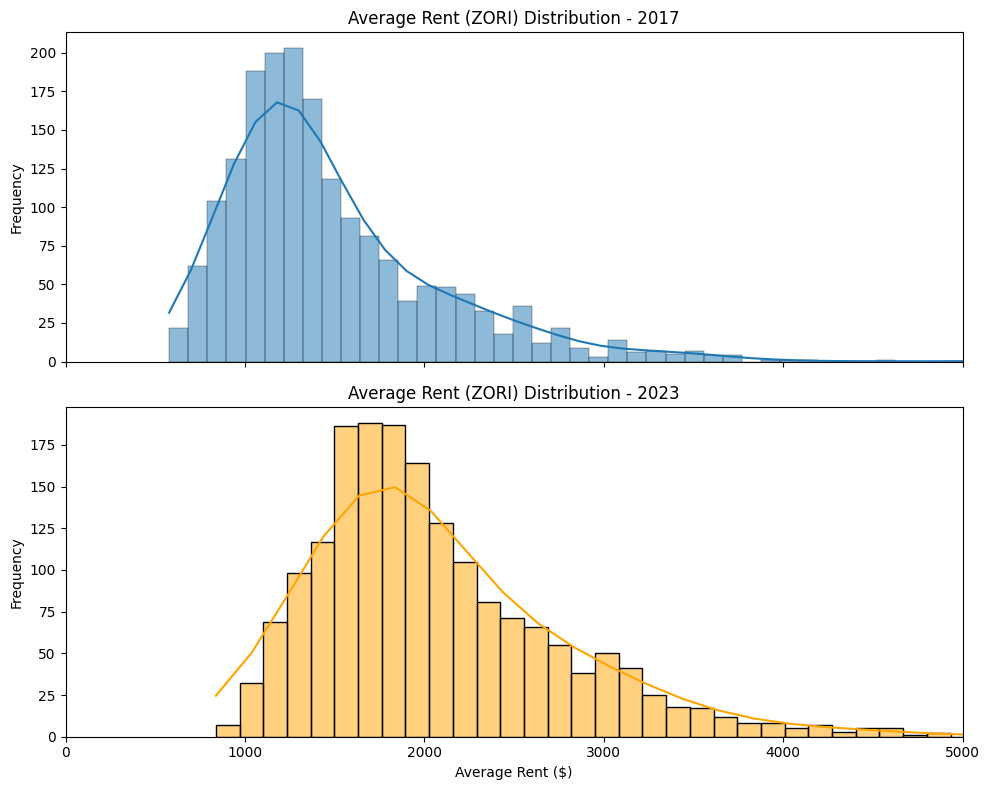

In [59]:
# Create subplots (2 rows, 1 column)
# sharex=True aligns the x-axis for easier comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for 2017 on the top subplot (axes[0])
sns.histplot(df_2017['average_zori'], ax=axes[0], kde=True)
axes[0].set_title('Average Rent (ZORI) Distribution - 2017')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 5000) # Limit x-axis to 0-5000

# Plot for 2023 on the bottom subplot (axes[1])
sns.histplot(df_2023['average_zori'], ax=axes[1], kde=True, color='orange')
axes[1].set_title('Average Rent (ZORI) Distribution - 2023')
axes[1].set_xlabel('Average Rent ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 5000) # Limit x-axis to 0-5000

plt.tight_layout()
plt.show()

These distributions appear skewed to the right. The shape resembles that of a binomial distribution. I will use a Q-Q plot to see how close the distribution is to a binomial one.

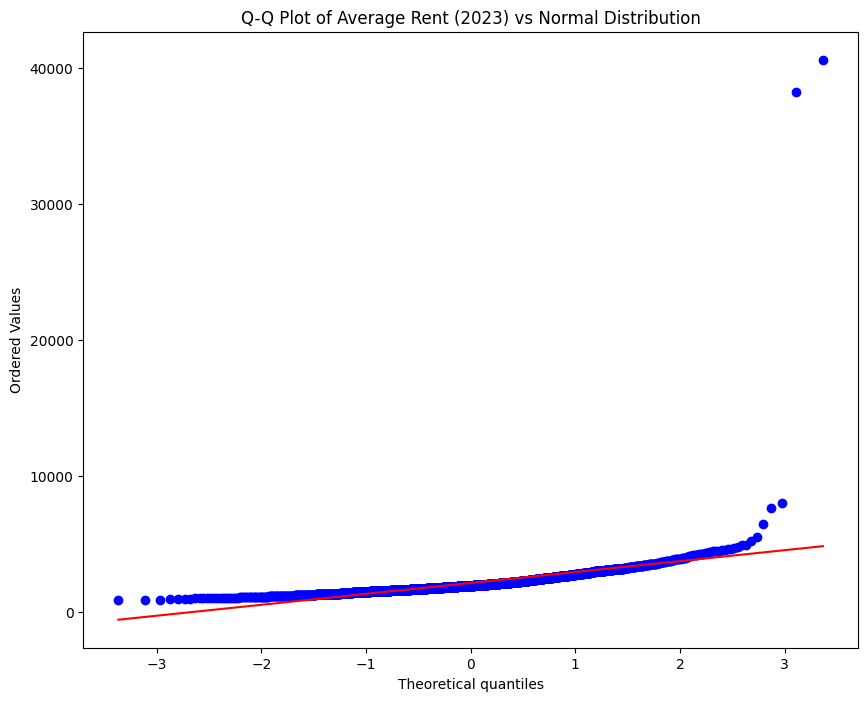

In [78]:
# Filter for year 2023 and 'average_zori', dropping missing values
data_2023 = rent_df[rent_df['year'] == 2023]['average_zori'].dropna()

# Create Q-Q plot against a Normal distribution
plt.figure(figsize=(10, 8))
# dist="norm" specifies the comparison against a normal distribution
stats.probplot(data_2023, dist="norm", plot=plt)
plt.title('Q-Q Plot of Average Rent (2023) vs Normal Distribution')
plt.show()

The distribution of these values closely resembles that of a binomial distribution. Next I will review the distribution of change in total housing units, share of the population that is rent burdened, and share of the population that is renter occupied.

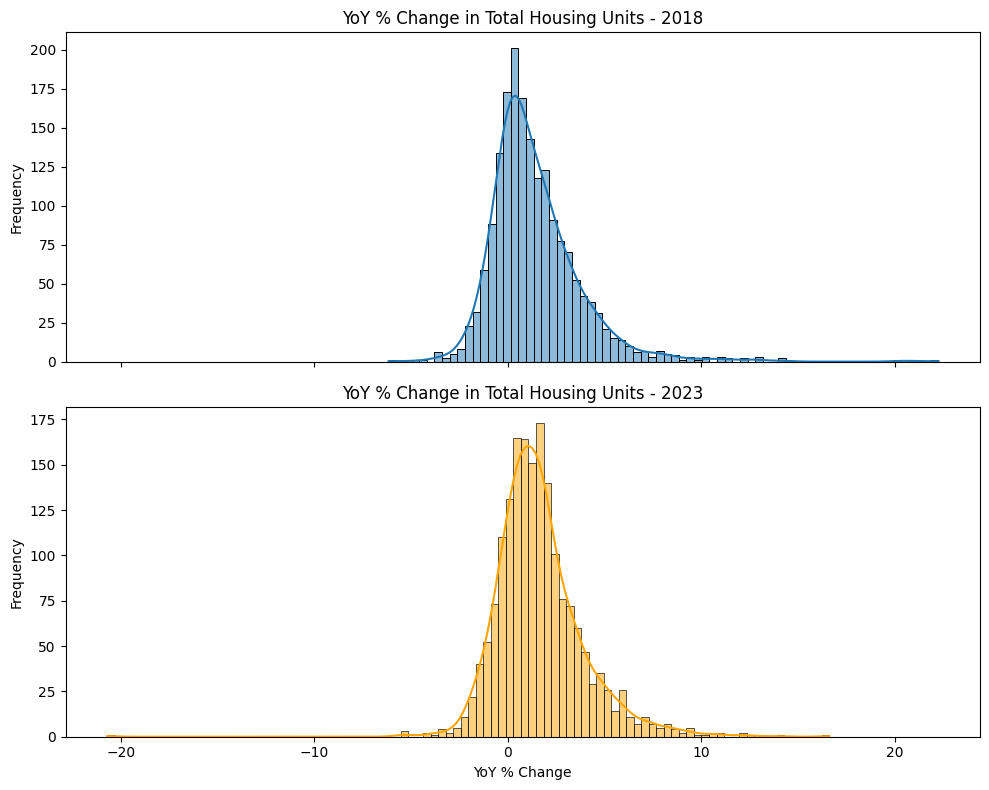

In [60]:
# Filter data for the specific years
df_2018 = rent_df[rent_df['year'] == 2018]

# Create subplots (2 rows, 1 column)
# sharex=True aligns the x-axis for easier comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for 2018 on the top subplot (axes[0])
# dropna() removes missing values to ensure the histogram plots correctly
sns.histplot(df_2018['yoy_pct_change_total_housing_units'].dropna(), ax=axes[0], kde=True)
axes[0].set_title('YoY % Change in Total Housing Units - 2018')
axes[0].set_ylabel('Frequency')

# Plot for 2023 on the bottom subplot (axes[1])
sns.histplot(df_2023['yoy_pct_change_total_housing_units'].dropna(), ax=axes[1], kde=True, color='orange')
axes[1].set_title('YoY % Change in Total Housing Units - 2023')
axes[1].set_xlabel('YoY % Change')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The average shifted to the right in 2023 from 2017, showing an increase in the supply of housing. These are fairly normally distributed plots. I am surprised by the amount of negative changes in housing stock, which is likely due to the decommissioning of properties.

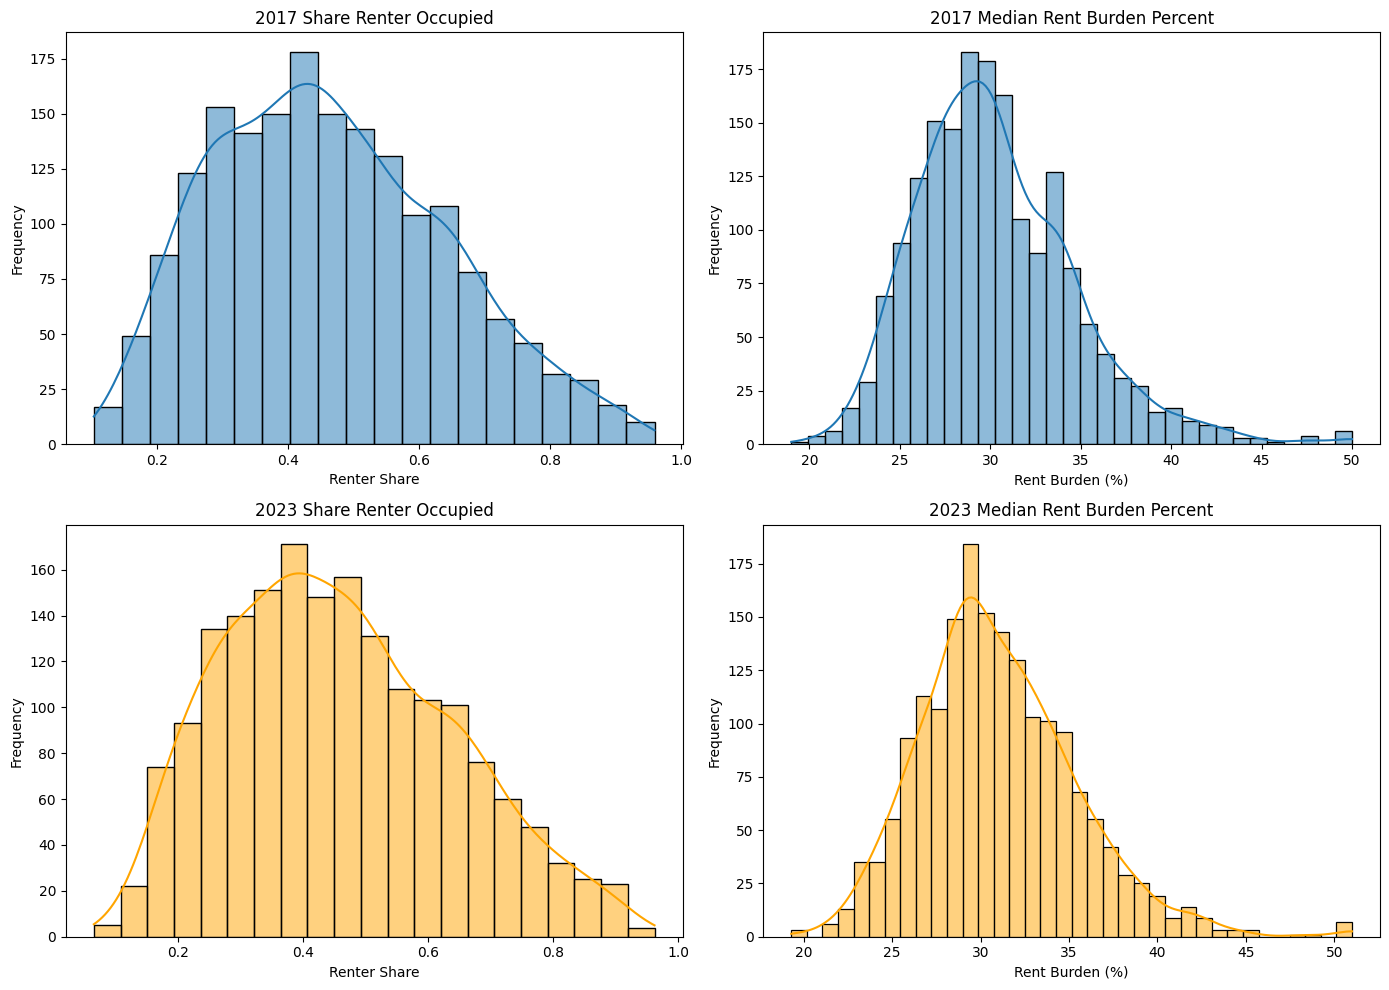

In [65]:
# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Row 1: 2017
# Col 1: Share Renter Occupied (rentership_rate)
sns.histplot(df_2017['rentership_rate'].dropna(), ax=axes[0, 0], kde=True)
axes[0, 0].set_title('2017 Share Renter Occupied')
axes[0, 0].set_xlabel('Renter Share')
axes[0, 0].set_ylabel('Frequency')

# Col 2: Median Rent Burden Percent
sns.histplot(df_2017['median_rent_burden_percent'].dropna(), ax=axes[0, 1], kde=True)
axes[0, 1].set_title('2017 Median Rent Burden Percent')
axes[0, 1].set_xlabel('Rent Burden (%)')
axes[0, 1].set_ylabel('Frequency')

# Row 2: 2023
# Col 1: Share Renter Occupied (rentership_rate)
sns.histplot(df_2023['rentership_rate'].dropna(), ax=axes[1, 0], kde=True, color='orange')
axes[1, 0].set_title('2023 Share Renter Occupied')
axes[1, 0].set_xlabel('Renter Share')
axes[1, 0].set_ylabel('Frequency')

# Col 2: Median Rent Burden Percent
sns.histplot(df_2023['median_rent_burden_percent'].dropna(), ax=axes[1, 1], kde=True, color='orange')
axes[1, 1].set_title('2023 Median Rent Burden Percent')
axes[1, 1].set_xlabel('Rent Burden (%)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

There do not seem to be significant shifts in these two characteristics over the 7 years. The mode of the renter share is near 40%, and the mode of the median rent burden percent is around 30%. If someone is rent burdened, it means that they spend more than 30% of their income on housing costs. According to the [Census](https://www.census.gov/newsroom/press-releases/2024/renter-households-cost-burdened-race.html), nearly half of the US is rent burdened. This shows that this dataset is not reflective of the whole US, and represents a larger share of the population that is not rent burdened.

Next, I will look at statistics based on their income grouping. For a better analysis, I remove the data from the Hamptons so that it doesn't distort the average rent plot.

Income Group Ranges (Median Household Income):
Group           | Range                         
---------------------------------------------
Low             | $28,040 - $69,596
Medium-Low      | $69,596 - $88,504
Medium-High     | $88,504 - $113,542
High            | $113,542 - $250,001


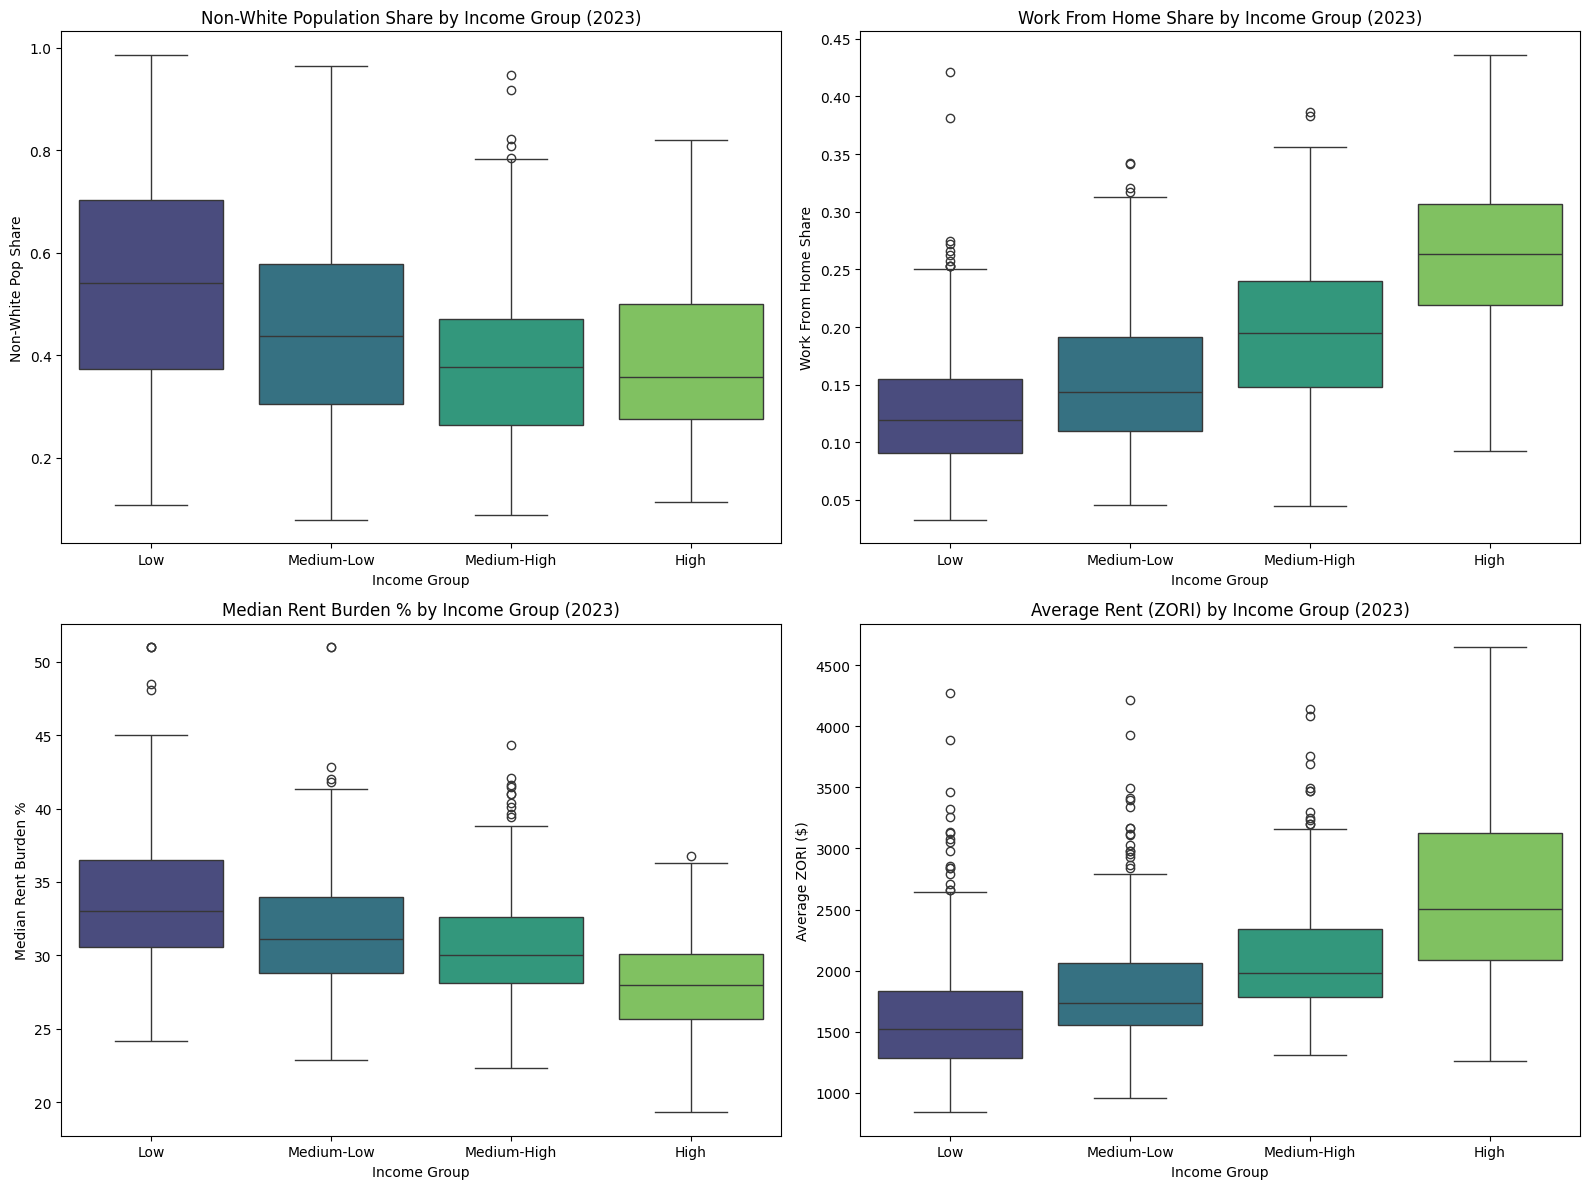

In [67]:
df_2023_clean = df_2023.dropna(subset=['median_household_income'])

# Create income groups and get the bin edges
df_2023_clean['income_group'], bins = pd.qcut(
    df_2023_clean['median_household_income'],
    q=4,
    labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
    retbins=True
)

# Print the income level table
income_groups = ['Low', 'Medium-Low', 'Medium-High', 'High']
print("Income Group Ranges (Median Household Income):")
print(f"{'Group':<15} | {'Range':<30}")
print("-" * 45)
for i, group in enumerate(income_groups):
    lower = bins[i]
    upper = bins[i+1]
    print(f"{group:<15} | ${lower:,.0f} - ${upper:,.0f}")

# Remove outliers for the 'High' income group for the plotted variables
metrics = ['non_white_pop_share', 'share_work_from_home', 'median_rent_burden_percent', 'average_zori']

for metric in metrics:
    # Calculate IQR stats for the High group
    high_group_data = df_2023_clean[df_2023_clean['income_group'] == 'High'][metric]
    Q1 = high_group_data.quantile(0.25)
    Q3 = high_group_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outlier indices
    outliers_mask = (high_group_data < lower_bound) | (high_group_data > upper_bound)
    outliers_indices = high_group_data[outliers_mask].index

    # Set outliers to NaN so they are excluded from the plot
    df_2023_clean.loc[outliers_indices, metric] = np.nan

# Define a palette
palette = "viridis"

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Non-white population share
sns.boxplot(x='income_group', y='non_white_pop_share', data=df_2023_clean, ax=axes[0, 0], hue='income_group', palette=palette)
axes[0, 0].set_title('Non-White Population Share by Income Group (2023)')
axes[0, 0].set_xlabel('Income Group')
axes[0, 0].set_ylabel('Non-White Pop Share')
# Remove legend if it exists
if axes[0, 0].get_legend():
    axes[0, 0].get_legend().remove()

# 2. Share of workers who worked from home
sns.boxplot(x='income_group', y='share_work_from_home', data=df_2023_clean, ax=axes[0, 1], hue='income_group', palette=palette)
axes[0, 1].set_title('Work From Home Share by Income Group (2023)')
axes[0, 1].set_xlabel('Income Group')
axes[0, 1].set_ylabel('Work From Home Share')
if axes[0, 1].get_legend():
    axes[0, 1].get_legend().remove()

# 3. Median rent burden percent
sns.boxplot(x='income_group', y='median_rent_burden_percent', data=df_2023_clean, ax=axes[1, 0], hue='income_group', palette=palette)
axes[1, 0].set_title('Median Rent Burden % by Income Group (2023)')
axes[1, 0].set_xlabel('Income Group')
axes[1, 0].set_ylabel('Median Rent Burden %')
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().remove()

# 4. Average zori
sns.boxplot(x='income_group', y='average_zori', data=df_2023_clean, ax=axes[1, 1], hue='income_group', palette=palette)
axes[1, 1].set_title('Average Rent (ZORI) by Income Group (2023)')
axes[1, 1].set_xlabel('Income Group')
axes[1, 1].set_ylabel('Average ZORI ($)')
if axes[1, 1].get_legend():
    axes[1, 1].get_legend().remove()

plt.tight_layout()
plt.show()

These metrics follow predictable trends. As income increases, the average of the non-white share of the population decreases and the average of the median rent burden share also decreases. The two variables that increase with income level are the share of people that work from home, and the average rent.

Next I will look at the change in housing supply over time.

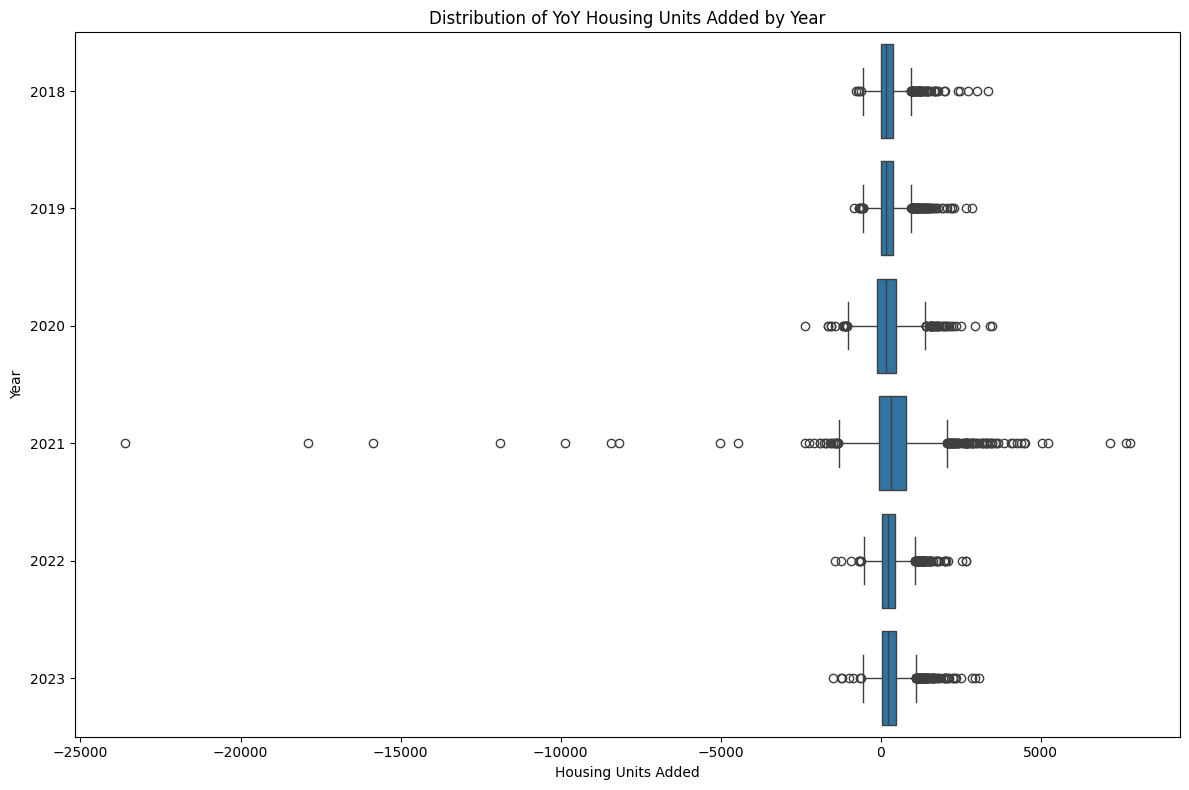

In [74]:
# Ensure data is sorted by zip and year for correct diff calculation
df = rent_df.sort_values(by=['zip_code', 'year'])

# Calculate absolute change in housing units year-over-year
# This subtracts the previous year's count from the current year's count for each zip code
df['housing_units_added'] = df.groupby('zip_code')['total_housing_units'].diff()

# Drop rows with NaN in 'housing_units_added' (the first year for each zip code will be NaN)
df_plot = df.dropna(subset=['housing_units_added'])

# Create the box plot
plt.figure(figsize=(12, 8))
# orient='h' creates a horizontal box plot
# converting year to string ensures it is treated as a categorical variable on the y-axis
sns.boxplot(data=df_plot, x='housing_units_added', y=df_plot['year'].astype(str), orient='h')

plt.title('Distribution of YoY Housing Units Added by Year')
plt.xlabel('Housing Units Added')
plt.ylabel('Year')

plt.tight_layout()
plt.show()

While this plot shows that there is not a significant trend in the supply of houses, it confirms my earlier suspicion that there was something strange about the 2021 housing supply statistics. I will now clean the data set to remove these extreme values as well as the extreme average rent values from the Hamptons.

In [79]:
# Save separate dataframe for clean values (rent_df_2)
df = rent_df.sort_values(by=['zip_code', 'year'])
df['housing_units_added'] = df.groupby('zip_code')['total_housing_units'].diff()

# 1. Identify extreme outliers for housing_units_added in 2021
data_2021 = df[df['year'] == 2021]['housing_units_added'].dropna()
Q1 = data_2021.quantile(0.25)
Q3 = data_2021.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Using 3*IQR for "extreme" outliers
upper_bound = Q3 + 3 * IQR

# Identify outlier indices for 2021
outliers_2021 = df[
    (df['year'] == 2021) &
    ((df['housing_units_added'] < lower_bound) | (df['housing_units_added'] > upper_bound))
].index

# 2. Identify indices for East Hampton and Southampton
rent_outliers = df[df['City'].isin(['East Hampton', 'Southampton'])].index

# 3. Create rent_df_2 by dropping these rows
indices_to_drop = outliers_2021.union(rent_outliers)
rent_df_2 = df.drop(indices_to_drop).copy()

The "extreme outliers" for housing units added in 2021 and the rows for East Hampton and Southampton have been removed. The new dataframe is saved as rent_df_2.
* Original Rows: 12,642
* Rows Dropped: 42
  * 28 rows were removed as extreme outliers for housing units added in 2021 (using the $3 \times IQR$ rule).
  * 14 rows were removed for East Hampton and Southampton.
* Final Rows: 12,600

This cleaned dataset will allow us to get a better visual of relationships between variables.

## 4.3 Between Variable Relationships

I will start by creating a pair plot to get a high level view of the relationship between certain variables.

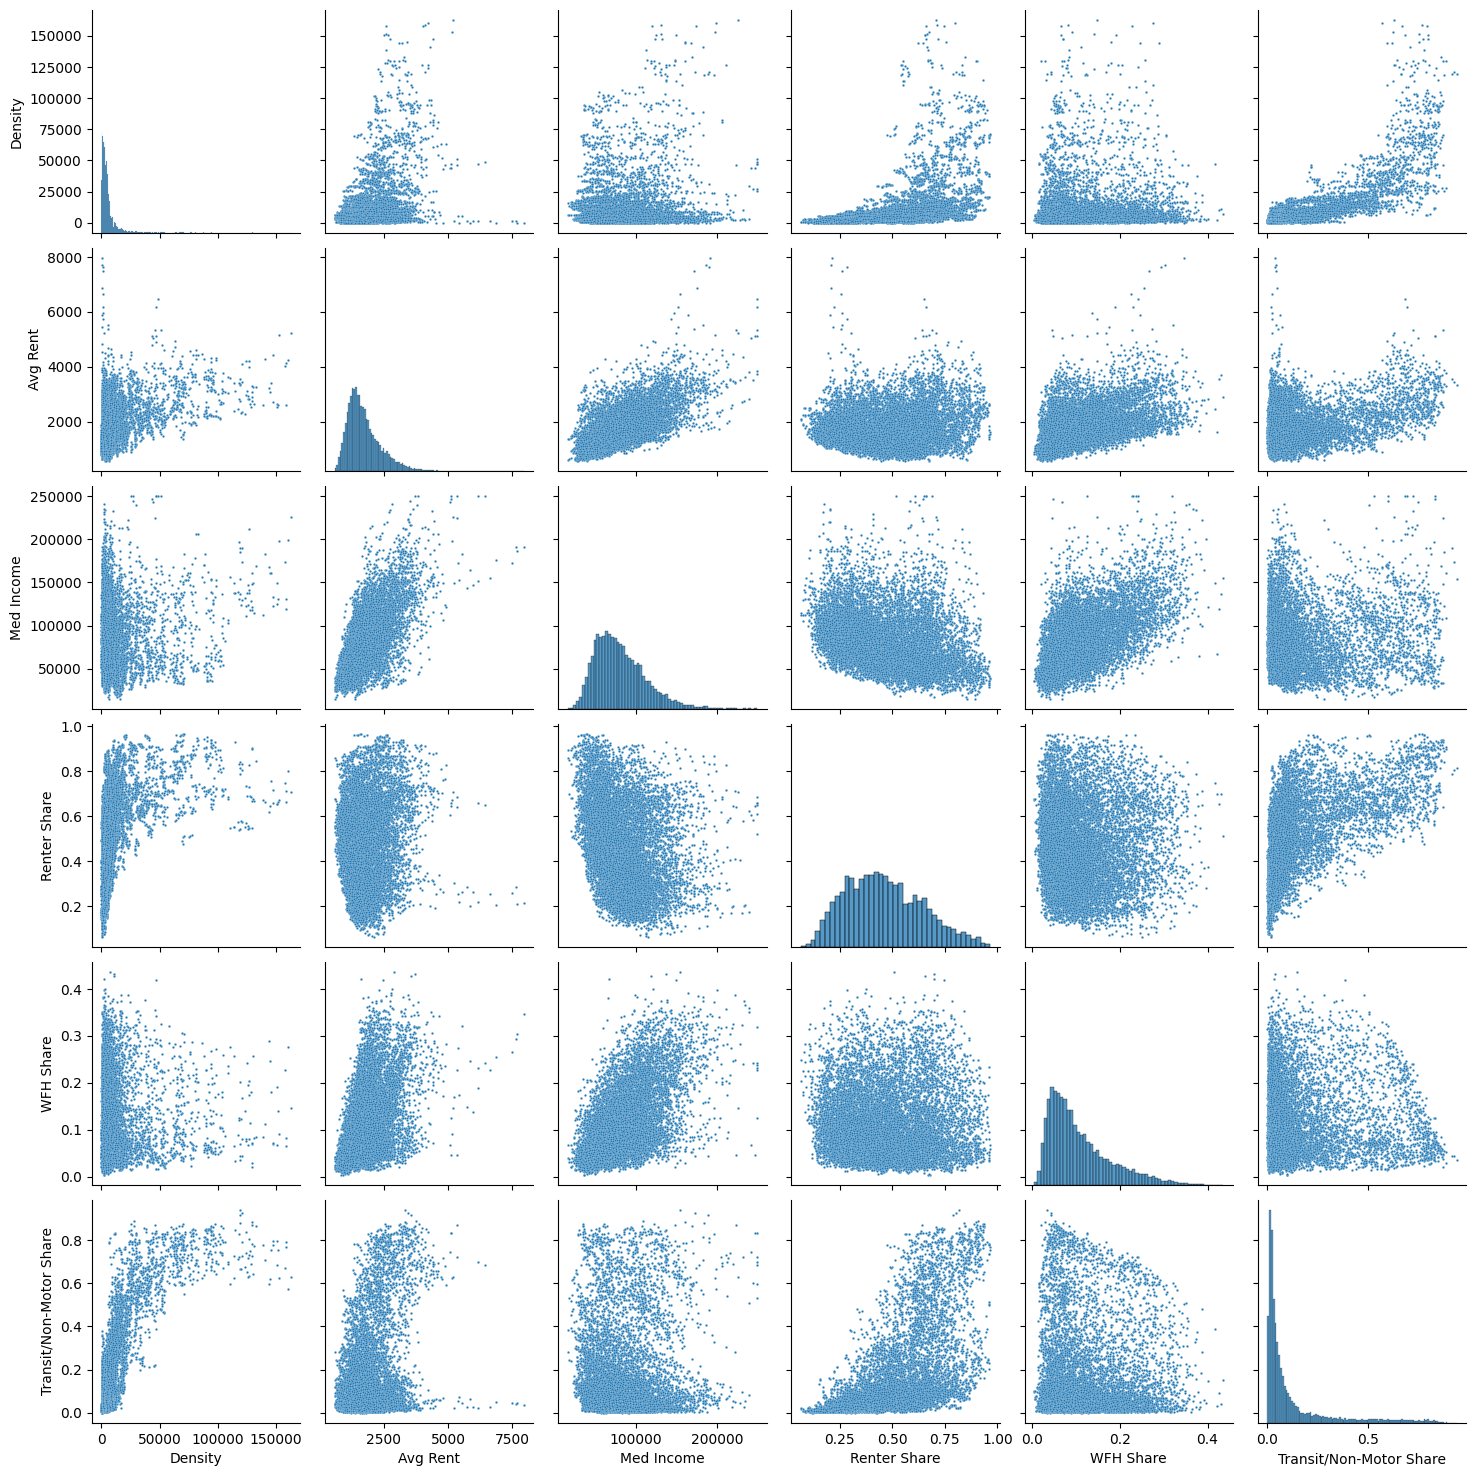

In [86]:
# List of variables to plot
cols_to_plot = [
    'zip_pop_density_sq_mi',
    'average_zori',
    'median_household_income',
    'rentership_rate',           # share renter occupied
    'share_work_from_home',
    'share_transit_nonmotorized'
]

# Create a subset dataframe with relevant columns
df_subset = rent_df_2[cols_to_plot].copy()

# Rename columns for cleaner plot labels
df_subset = df_subset.rename(columns={
    'zip_pop_density_sq_mi': 'Density',
    'average_zori': 'Avg Rent',
    'median_household_income': 'Med Income',
    'rentership_rate': 'Renter Share',
    'share_work_from_home': 'WFH Share',
    'share_transit_nonmotorized': 'Transit/Non-Motor Share'
})

# Drop rows with NaN values to ensure plotting works correctly
df_subset = df_subset.dropna()

# Generate the pair plot
# plot_kws={'s': 3} sets the size of the points to be smaller for better visibility
sns.pairplot(df_subset, plot_kws={'s': 3})

plt.show()

Some trends I observe are the interesting curve relationship between population density and the share of people that don't use cars, the positive relationship between average rent and median income, and the positive relationship between the work from home share and both the average rent and median income.

I also notice the lack of a trend between renter share and median income. I would have guessed that as the median income increased, there would be less renting in the zip code. This does not appear to be the case.

Next, I will look more closely at the curve relationship between population density and the share of people that don't use cars.

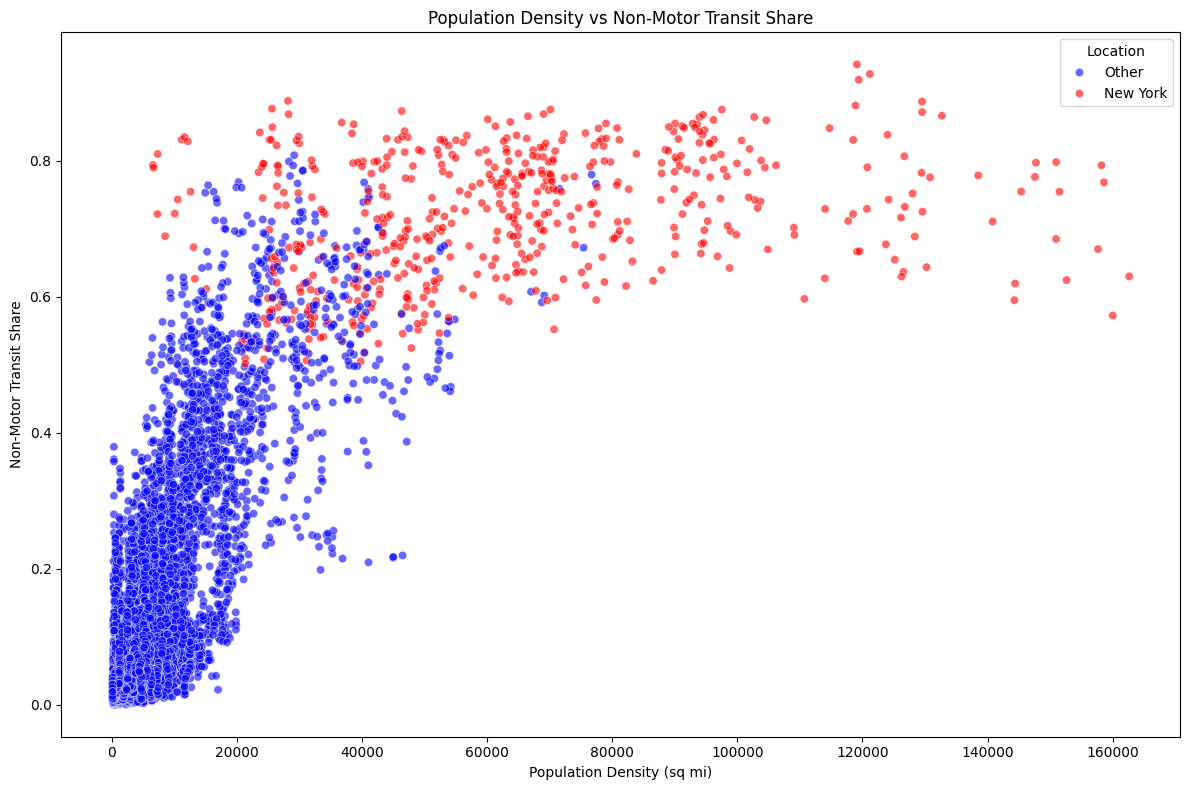

In [89]:
# Filter for year 2023
df = rent_df_2.copy()

# Create a category for New York vs Others
# This lambda function checks if the city is "New York" and assigns the label accordingly
df['Location'] = df['City'].apply(lambda x: 'New York' if x == 'New York' else 'Other')

# Drop rows with missing values in relevant columns
df = df.dropna(subset=['zip_pop_density_sq_mi', 'share_transit_nonmotorized'])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='zip_pop_density_sq_mi',
    y='share_transit_nonmotorized',
    hue='Location',
    alpha=0.6,
    palette={'New York': 'red', 'Other': 'blue'} # Set custom colors
)

plt.title('Population Density vs Non-Motor Transit Share')
plt.xlabel('Population Density (sq mi)')
plt.ylabel('Non-Motor Transit Share')
plt.legend(title='Location')

plt.tight_layout()
plt.show()

Not suprisingly, the curvature comes from New York zip codes that heavily rely on public transportation. This can be observed by the red points on the plot.

## 4.4 Time Series

A few variables I want to analyze over time are median household income and average rent. I take the average to make the calculation simple.

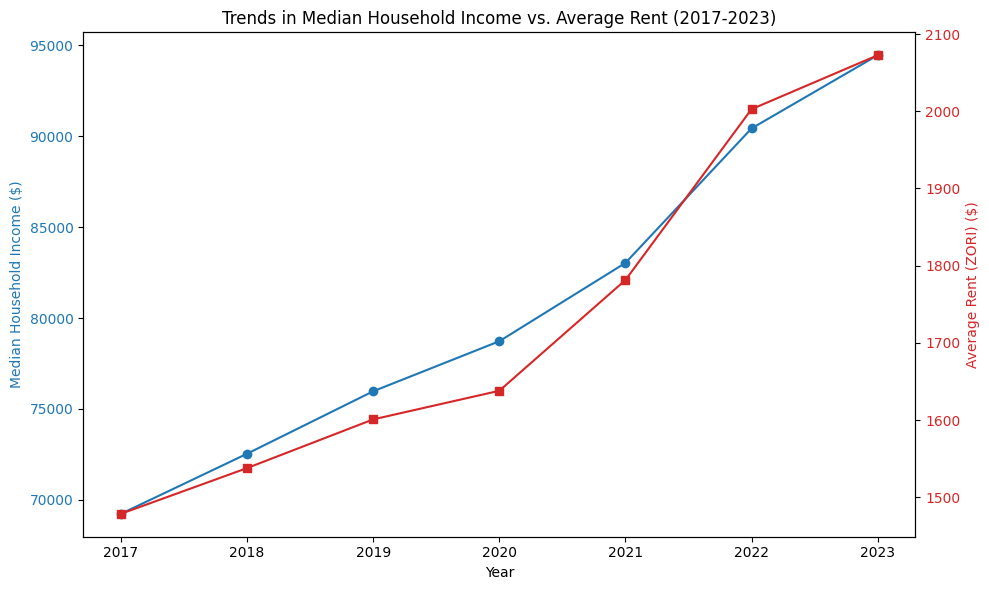

In [90]:
# Group by year and calculate the average for income and rent
annual_trends = rent_df_2.groupby('year')[['median_household_income', 'average_zori']].mean().reset_index()

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Median Household Income on the primary y-axis (left)
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Household Income ($)', color=color)
ax1.plot(annual_trends['year'], annual_trends['median_household_income'], color=color, marker='o', label='Median Income')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis (right)
ax2 = ax1.twinx()

# Plot Average Rent (ZORI) on the secondary y-axis
color = 'tab:red'
ax2.set_ylabel('Average Rent (ZORI) ($)', color=color)
ax2.plot(annual_trends['year'], annual_trends['average_zori'], color=color, marker='s', label='Average Rent')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title
plt.title('Trends in Median Household Income vs. Average Rent (2017-2023)')

# Improve layout
fig.tight_layout()

# Show the plot
plt.show()

Between 2017 and 2023, the average of the median household income increases from \$70,000 to almost \$95,000, an increase of \$2083 per month. The average monthly rent increased from \$1,500 to \$2,075, an increase of \$575. According to this data, income in these metropolitan areas is increasing more than the rent.

Since we are observing years before and after the COVID-19 pandemic, it will also be interesting to see the change in the share of people that work from home.

year
2017    0.057754
2018    0.060163
2019    0.063564
2020    0.094622
2021    0.130591
2022    0.159653
2023    0.184531
Name: share_work_from_home, dtype: float64


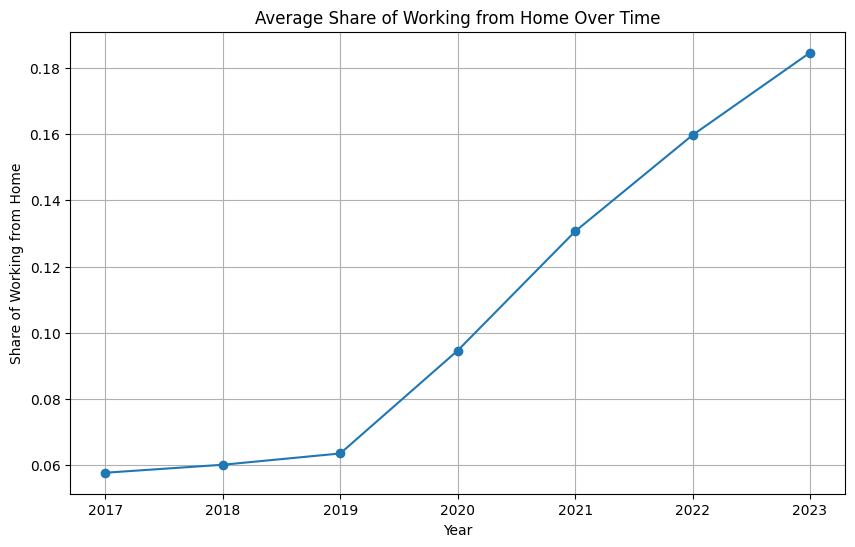

In [91]:
# Calculate the average share of working from home by year
# We group the data by 'year' and take the mean of the 'share_work_from_home' column
avg_wfh_by_year = df.groupby('year')['share_work_from_home'].mean()

# Display the calculated values
print(avg_wfh_by_year)

# Plot the results
plt.figure(figsize=(10, 6))
avg_wfh_by_year.plot(kind='line', marker='o')
plt.title('Average Share of Working from Home Over Time')
plt.xlabel('Year')
plt.ylabel('Share of Working from Home')
plt.grid(True)
plt.show()

This trend is surprising, because I would have expected it to start decreasing, but this trend shows a continued increase through 2023 after the pandemic hit in 2020. An upwards trend already existed before 2020, showing how COVID sped up a process that was already on in progress.

# 5. Formal Data Analysis

## 5.1 Change in rent vs change in supply

In this final section, I will look at the relationship specifically between housing supply growth and average rent growth. I begin by looking at correlations between the changes in variables I had calculated in the data processing stage.

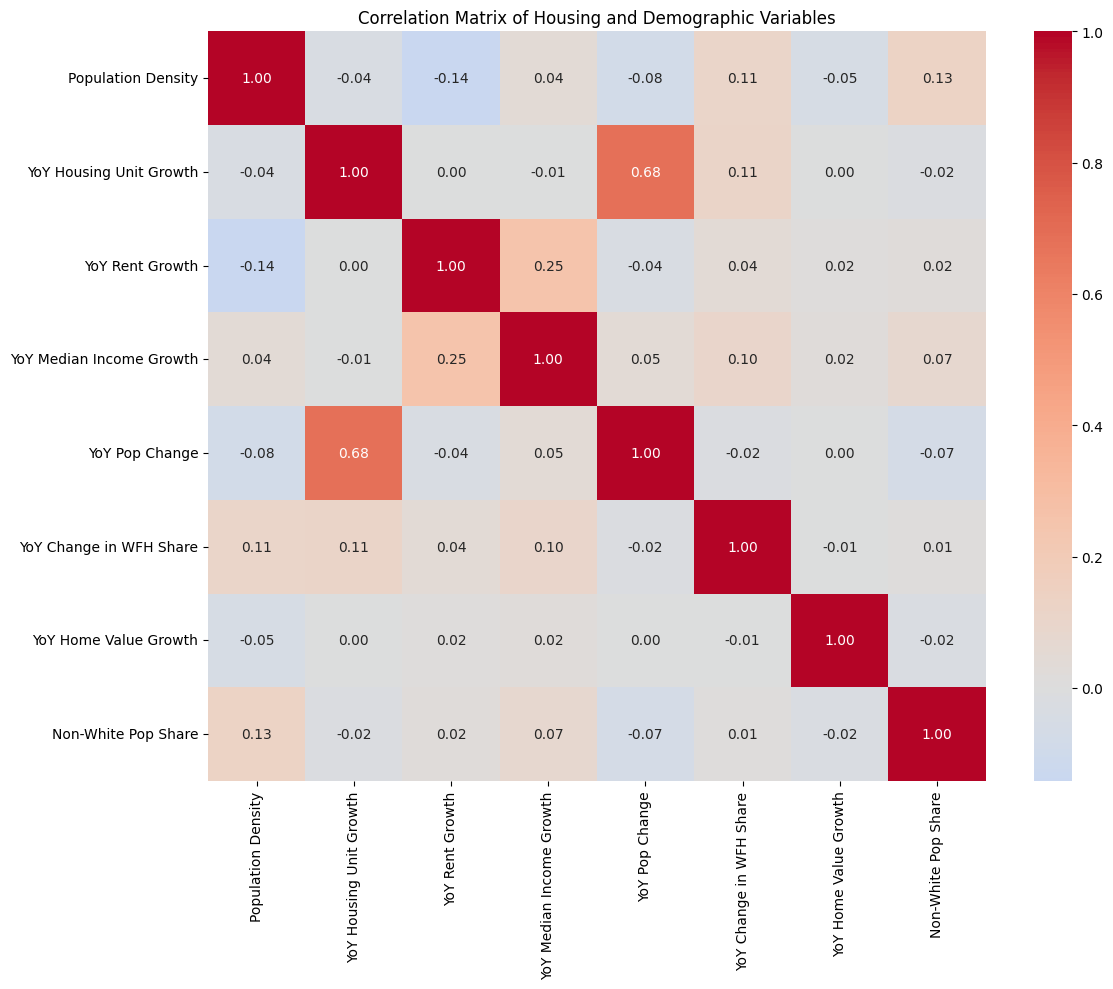

In [103]:
# List of variables to include in the correlation matrix
cols_to_corr = [
    'zip_pop_density_sq_mi',
    'yoy_pct_change_total_housing_units',
    'yoy_pct_change_average_zori',
    'yoy_pct_change_median_household_income',
    'yoy_pct_change_population',
    'yoy_abs_change_share_work_from_home',
    'yoy_pct_change_median_home_value',
    'non_white_pop_share'
]

# Create a dictionary to rename columns for better readability on the plot
labels_map = {
    'zip_pop_density_sq_mi': 'Population Density',
    'yoy_pct_change_total_housing_units': 'YoY Housing Unit Growth',
    'yoy_pct_change_average_zori': 'YoY Rent Growth',
    'yoy_pct_change_median_household_income': 'YoY Median Income Growth',
    'yoy_pct_change_population': 'YoY Pop Change',
    'yoy_abs_change_share_work_from_home': 'YoY Change in WFH Share',
    'yoy_pct_change_median_home_value': 'YoY Home Value Growth',
    'non_white_pop_share': 'Non-White Pop Share'
}

# Calculate the correlation matrix
# We select the columns, rename them, and then call .corr()
corr_matrix = rent_df_2[cols_to_corr].rename(columns=labels_map).corr()

# Set up the matplotlib figure size
plt.figure(figsize=(12, 10))

# Plot the heatmap using seaborn
# annot=True adds the numbers to the squares
# cmap='coolwarm' sets the color scheme (blue for negative, red for positive)
# fmt=".2f" formats the numbers to 2 decimal places
# center=0 ensures that 0 is the neutral color (white/grey)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)

# Add title and adjust layout
plt.title('Correlation Matrix of Housing and Demographic Variables')
plt.tight_layout()

# Show the plot
plt.show()

Most of these variables have very weak relationships, with the exception of change in population and housing unit growth (corr = 0.68). Correlation between ncome growth and rent growth is the second highest. Surprisingly, the correlation between housing unit growth and rent growth is 0. I proceed to run a regression analysis.  

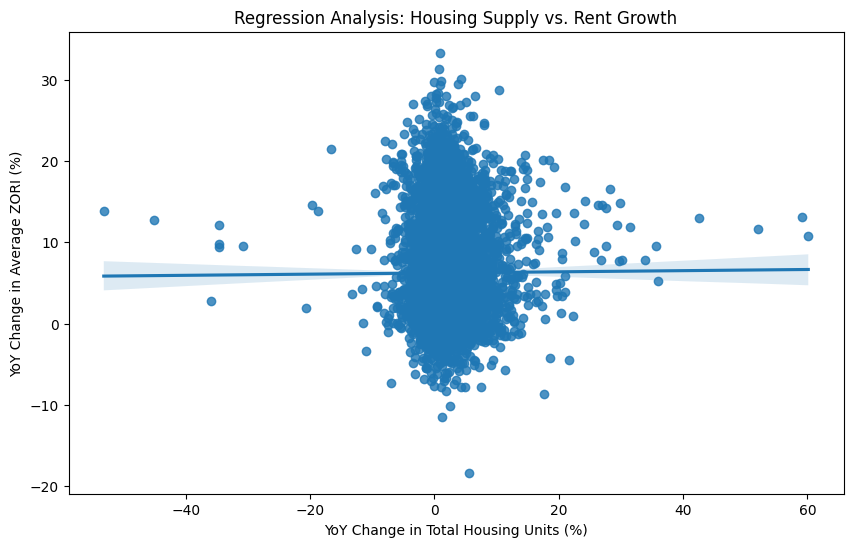

In [98]:
# Assuming rent_df is already loaded and cleaned
plt.figure(figsize=(10, 6))
sns.regplot(x='yoy_pct_change_total_housing_units', y='yoy_pct_change_average_zori', data=rent_df)
plt.title('Regression Analysis: Housing Supply vs. Rent Growth')
plt.xlabel('YoY Change in Total Housing Units (%)')
plt.ylabel('YoY Change in Average ZORI (%)')
plt.show()

Analyzing the change in supply and rent every year may not be capturing the effect, since a change in housing supply may effect rental prices in the longer term. Next, I will only look at the relationship between the first and final year, as was done by the Pew Research center.

                            OLS Regression Results                            
Dep. Variable:        pct_change_zori   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     28.28
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           1.18e-07
Time:                        02:06:23   Log-Likelihood:                 629.89
No. Observations:                1803   AIC:                            -1256.
Df Residuals:                    1801   BIC:                            -1245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4538      0

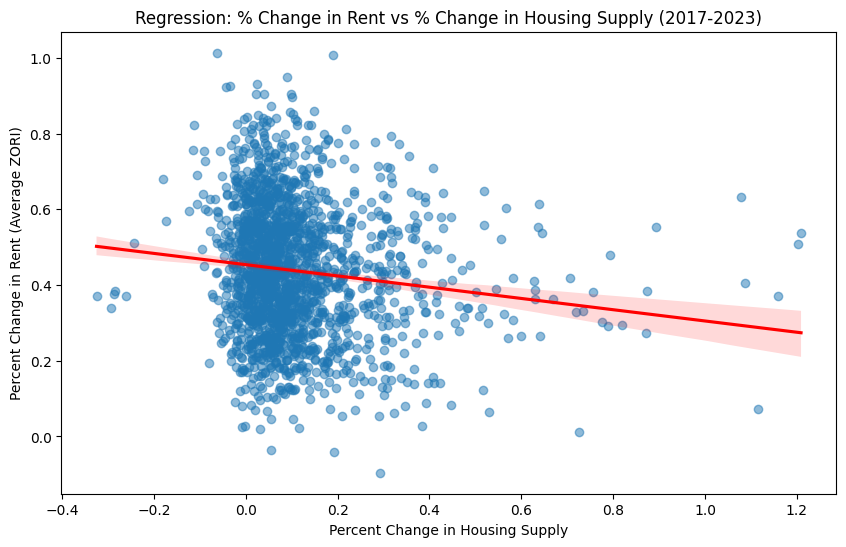

In [102]:
# 1. Filter for 2017 and 2023
df_filtered = rent_df[rent_df['year'].isin([2017, 2023])].copy()

# 2. Pivot the data to have years as columns for easy calculation
# We pivot on zip_code to align 2017 and 2023 values
df_pivot = df_filtered.pivot(index='zip_code', columns='year', values=['average_zori', 'total_housing_units'])

# 3. Calculate Percent Changes
# Formula: (Value_2023 - Value_2017) / Value_2017
pct_change_zori = (df_pivot['average_zori'][2023] - df_pivot['average_zori'][2017]) / df_pivot['average_zori'][2017]
pct_change_housing = (df_pivot['total_housing_units'][2023] - df_pivot['total_housing_units'][2017]) / df_pivot['total_housing_units'][2017]

# Create a clean DataFrame for analysis, dropping any rows with missing data (NaN)
analysis_df = pd.DataFrame({
    'pct_change_housing': pct_change_housing,
    'pct_change_zori': pct_change_zori
}).dropna()

# 4. Run Regression
# Define dependent (y) and independent (X) variables
X = sm.add_constant(analysis_df['pct_change_housing']) # Add a constant (intercept) term
y = analysis_df['pct_change_zori']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the regression summary table
print(model.summary())

# 5. Plot the Regression in Seaborn
plt.figure(figsize=(10, 6))
sns.regplot(x='pct_change_housing', y='pct_change_zori', data=analysis_df,
            line_kws={"color": "red"}, scatter_kws={'alpha':0.5})
plt.title('Regression: % Change in Rent vs % Change in Housing Supply (2017-2023)')
plt.xlabel('Percent Change in Housing Supply')
plt.ylabel('Percent Change in Rent (Average ZORI)')

# Save the plot
plt.savefig('regression_plot.png')

In this regression analysis, there is a slightly more dominant relationship showing that an increase in housing supply and a decrease in average rents. The P value is nearly 0, with the coefficient at -.1488. Next I will add in some of the control variables.

## 5.2 Include controls in analysis

                            OLS Regression Results                            
Dep. Variable:        pct_change_zori   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     157.4
Date:                Sat, 06 Dec 2025   Prob (F-statistic):          5.60e-201
Time:                        02:11:09   Log-Likelihood:                 1095.3
No. Observations:                1803   AIC:                            -2173.
Df Residuals:                    1794   BIC:                            -2123.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

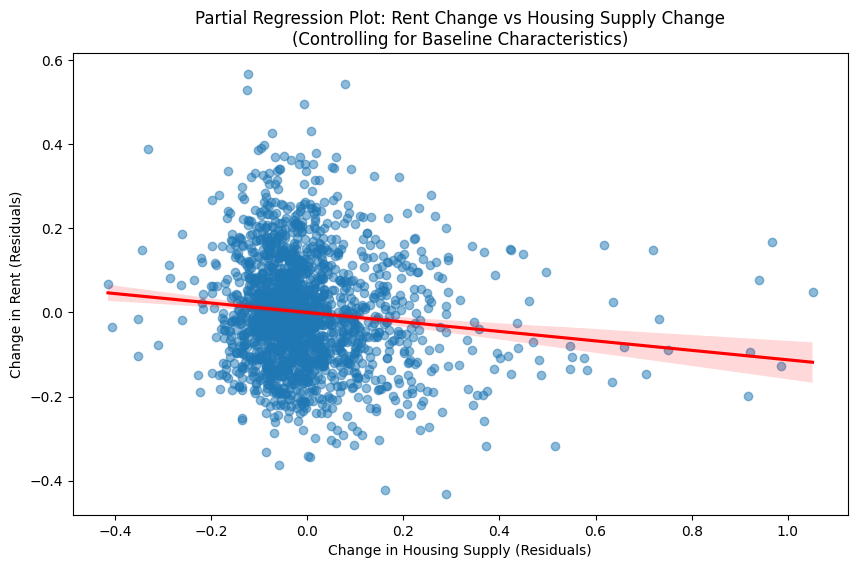

In [104]:
# 1. Filter and Prepare Data
# Separate 2017 and 2023 data
df_17 = rent_df[rent_df['year'] == 2017].set_index('zip_code')
df_23 = rent_df[rent_df['year'] == 2023].set_index('zip_code')

# Find common zip codes to ensure alignment
common_zips = df_17.index.intersection(df_23.index)
df_17 = df_17.loc[common_zips]
df_23 = df_23.loc[common_zips]

# 2. Calculate Variables
# Dependent Variable: % Change in Rent (2017 to 2023)
y = (df_23['average_zori'] - df_17['average_zori']) / df_17['average_zori']

# Independent Variable of Interest: % Change in Housing Supply
x_main = (df_23['total_housing_units'] - df_17['total_housing_units']) / df_17['total_housing_units']

# Control Variables (using 2017 baseline values)
control_vars = ['zip_pop_density_sq_mi', 'non_white_pop_share', 'commute_worked_from_home',
                'median_household_income', 'median_home_value', 'rentership_rate', 'gini_inequality_index']
X_controls = df_17[control_vars]

# Combine into a single DataFrame for analysis
data = pd.DataFrame({
    'pct_change_zori': y,
    'pct_change_housing': x_main
})
data = data.join(X_controls)

# Drop missing values
data = data.dropna()

# 3. Run Regression
# Define Predictors: Main X + Controls + Constant
X = data[['pct_change_housing'] + control_vars]
X = sm.add_constant(X)
Y = data['pct_change_zori']

# Fit Model
model = sm.OLS(Y, X).fit()
print(model.summary())

# 4. Plotting (Partial Regression Plot using Seaborn)
# To visualize the specific effect of Housing Supply controlling for others, we plot the residuals.
# This "partials out" the effect of the control variables from both X and Y.

# Residuals of Y on Controls
model_y_controls = sm.OLS(data['pct_change_zori'], sm.add_constant(data[control_vars])).fit()
res_y = model_y_controls.resid

# Residuals of X on Controls
model_x_controls = sm.OLS(data['pct_change_housing'], sm.add_constant(data[control_vars])).fit()
res_x = model_x_controls.resid

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=res_x, y=res_y, line_kws={"color": "red"}, scatter_kws={'alpha': 0.5})
plt.title('Partial Regression Plot: Rent Change vs Housing Supply Change\n(Controlling for Baseline Characteristics)')
plt.xlabel('Change in Housing Supply (Residuals)')
plt.ylabel('Change in Rent (Residuals)')
plt.savefig('partial_regression_seaborn.png')

With the control variables, the coefficient decreases slightly to -0.1126, and the P value is still nearly 0. These results are similar to that of the Pew report.

# 6. Conclusion

This report aimed to investigate the relationship between housing supply and rental rates in the U.S. from 2017 to 2023, drawing inspiration from a Pew Research article. Data from Zillow (ZORI) and the American Community Survey (ACS) were collected, cleaned, and formatted, including the calculation of year-over-year changes for key variables. Preliminary exploratory data analysis revealed significant rent disparities across U.S. zip codes, with high-income areas like the Hamptons and Malibu experiencing the highest rents, while more affordable rents were found across the Midwest and Southwest. While the distributions of rentership rates and rent burden remained relatively stable, a notable upward trend in the share of the population working from home was observed, particularly after the COVID-19 pandemic. Interestingly, a time series analysis indicated that the average median household income increased more significantly than average monthly rent in the metropolitan areas studied between 2017 and 2023.

Further data analysis, including correlation and regression, explored the direct relationship between housing supply growth and rent growth. While initial correlations between most variables were weak, a strong positive correlation was noted between population change and housing unit growth. Regression analysis, focusing on the percent change in rent versus the percent change in housing supply from 2017 to 2023, revealed a statistically significant negative relationship, suggesting that an increase in housing supply correlates with a decrease in average rents. This inverse relationship persisted even after incorporating control variables such as population density, non-white population share, work-from-home rates, median household income, median home value, rentership rate, and the Gini inequality index. These findings align with the conclusions drawn by the Pew Research Center, reinforcing the idea that increased housing supply can play a role in mitigating rent growth.

In [15]:
### END OF NOTEBOOK